<a href="https://colab.research.google.com/github/mrkevinlin/MLmed/blob/master/keras_medicine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes:
#**- Determine imputation to use**

# **Initialize everything**

In [1]:
!pip install --upgrade -q gspread

from __future__ import print_function

import math
from google.colab import files
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 
from keras.wrappers.scikit_learn import KerasRegressor

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 15
pd.options.display.max_columns = 40
pd.options.display.float_format = '{:.3f}'.format

Using TensorFlow backend.


In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

# Create a DataFrame of patient data

**Import CSV to populate a DataFrame**

In [0]:
# Open Google Sheet of patient data and get column titles
patient_dataframe = gc.open('patient_data').sheet1
column_names = patient_dataframe.row_values(1)

# Process Google Sheet into a pandas dataframe of all numeric values
patient_dataframe = pd.DataFrame.from_records(
    patient_dataframe.get_all_values(),
    columns=column_names)
patient_dataframe = patient_dataframe.iloc[1:]
patient_dataframe = patient_dataframe.apply(pd.to_numeric, errors='coerce')
patient_dataframe = patient_dataframe.replace('', np.nan)
patient_dataframe_original = patient_dataframe.copy()


# **View some stats on the data**

,year,entry_knowledge,entry_hads_a,entry_hads_d,entry_height,entry_weight,entry_waist,entry_BF,entry_BMI,entry_6mwt,entry_met,entry_chol,entry_trig,entry_hdl,entry_ldl,exit_knowledge,exit_hads_a,exit_hads_d,exit_weight,exit_waist,exit_BF,exit_BMI,exit_6mwt,exit_met,exit_chol,exit_trig,exit_hdl,exit_ldl,entry_normal_a,entry_borderline_a,entry_severe_a,entry_normal_d,entry_borderline_d,entry_severe_d,exit_normal_a,exit_borderline_a,exit_severe_a,exit_normal_d,exit_borderline_d,exit_severe_d
count,566.000,478.000,487.000,411.000,441.000,523.000,506.000,491.000,407.000,376.000,487.000,330.000,330.000,328.000,323.000,118.000,121.000,88.000,123.000,123.000,121.000,86.000,80.000,124.000,97.000,97.000,98.000,98.000,566.000,566.000,566.000,566.000,566.000,566.000,566.000,566.000,566.000,566.000,566.000,566.000
mean,2016.756,67.383,5.072,5.088,66.714,192.452,39.385,29.948,30.313,1083.535,2.551,159.458,135.733,47.384,88.077,73.924,3.479,2.682,187.728,38.219,27.508,29.002,1493.312,3.263,150.948,107.546,54.112,76.755,0.641,0.118,0.101,0.542,0.097,0.087,0.186,0.023,0.005,0.143,0.009,0.004
std,1.149,20.886,4.413,4.316,4.378,47.627,5.889,8.189,6.552,392.374,0.513,47.339,130.403,15.538,37.438,19.176,3.349,3.124,43.234,5.480,7.540,5.250,351.040,0.682,41.186,59.681,17.704,30.487,0.480,0.323,0.301,0.499,0.296,0.281,0.389,0.150,0.073,0.350,0.094,0.059
min,2015.000,0.000,0.000,0.000,54.250,90.600,24.000,9.000,17.000,200.000,1.100,51.000,33.000,11.000,7.000,15.000,0.000,0.000,121.600,27.250,15.900,19.310,300.000,1.400,69.000,43.000,31.000,24.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2016.000,54.000,1.000,2.000,63.750,159.150,35.500,23.705,25.120,900.000,2.300,127.250,76.000,36.000,61.000,62.000,0.000,0.000,156.800,34.750,21.800,24.150,1361.250,2.900,124.000,72.000,41.000,54.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,2017.000,69.000,4.000,4.000,66.800,184.500,38.750,29.500,29.100,1100.000,2.600,152.000,107.000,45.000,84.000,77.000,3.000,2.000,182.400,37.500,26.810,28.300,1525.000,3.200,144.000,94.000,50.000,72.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,2018.000,85.000,8.000,8.000,70.000,218.200,43.000,36.000,34.375,1276.000,2.900,184.750,153.000,56.000,106.500,92.000,6.000,4.000,209.500,41.250,32.200,33.147,1701.000,3.625,167.000,121.000,61.750,92.500,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,2019.000,100.000,21.000,21.000,79.000,399.200,64.500,50.000,62.300,5422.000,6.500,342.000,1549.000,100.000,245.000,100.000,13.000,14.000,299.600,64.000,43.820,40.720,2189.000,6.200,289.000,389.000,118.000,169.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000



Number missing in each column:


year                   0
entry_knowledge       88
entry_hads_a          79
entry_hads_d         155
entry_height         125
entry_weight          43
entry_waist           60
                    ... 
entry_severe_d         0
exit_normal_a          0
exit_borderline_a      0
exit_severe_a          0
exit_normal_d          0
exit_borderline_d      0
exit_severe_d          0
Length: 40, dtype: int64

entry normal (a) count: 363
entry borderline (a) count: 67
entry severe (a) count: 57
entry normal (d) count: 307
entry borderline (d) count: 55
entry severe (d) count: 49
exit normal (a) count: 105
exit borderline (a) count: 13
exit severe (a) count: 3
exit normal (d) count: 81
exit borderline (d) count: 5
exit severe (d) count: 2


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


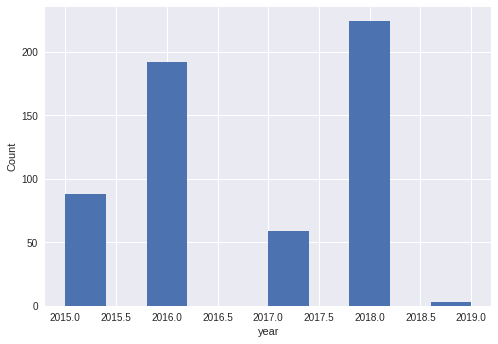

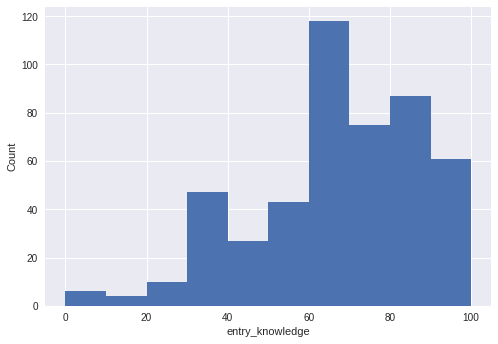

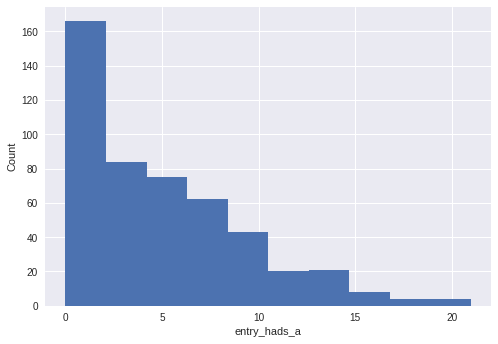

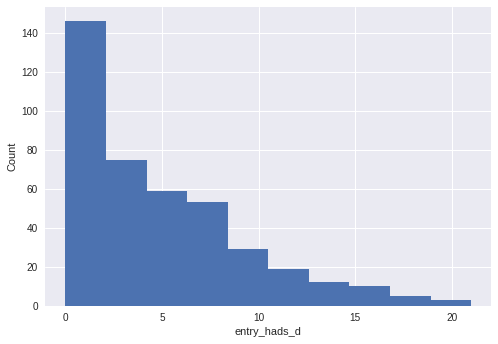

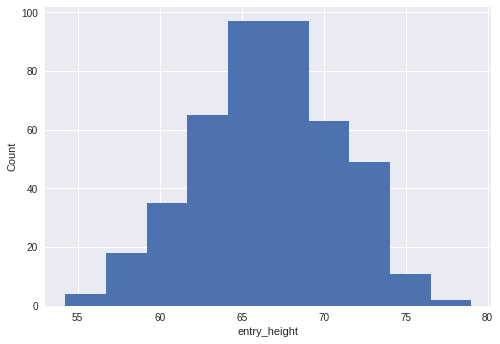

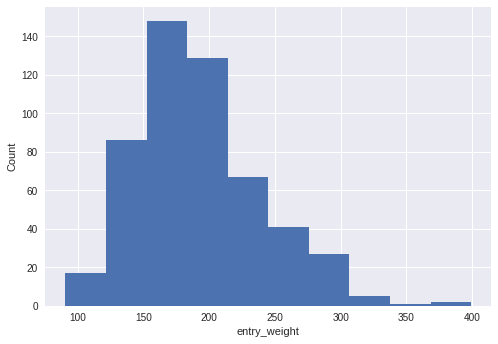

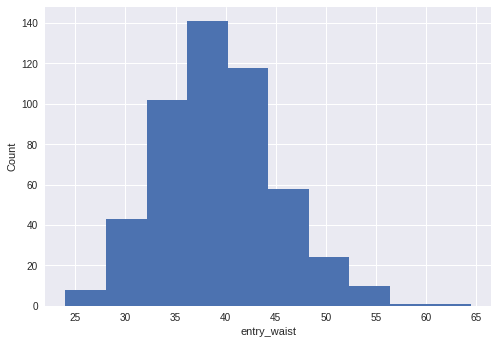

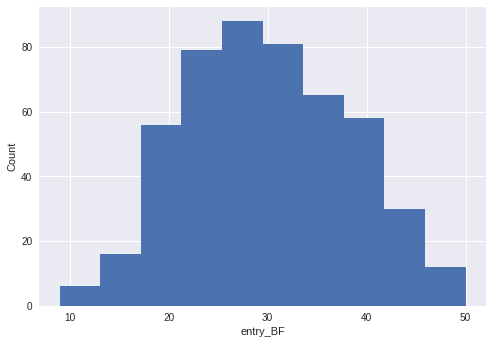

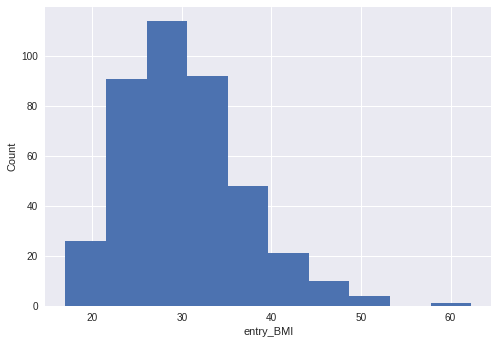

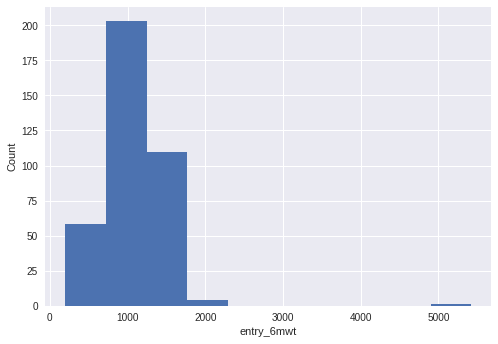

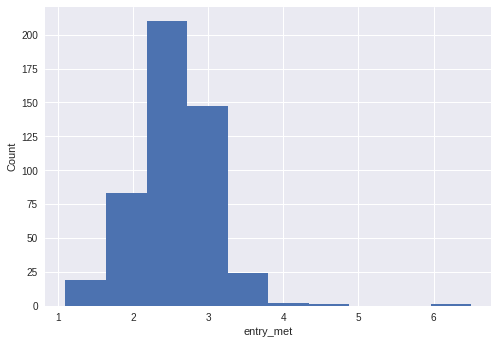

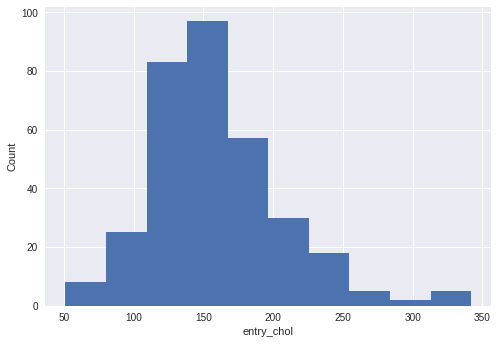

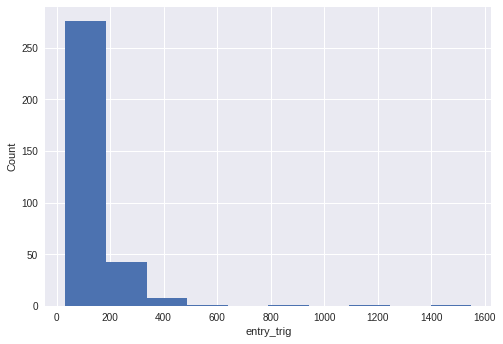

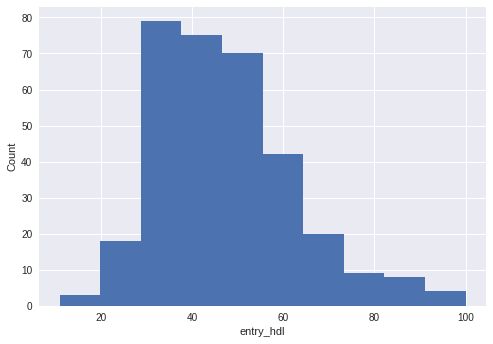

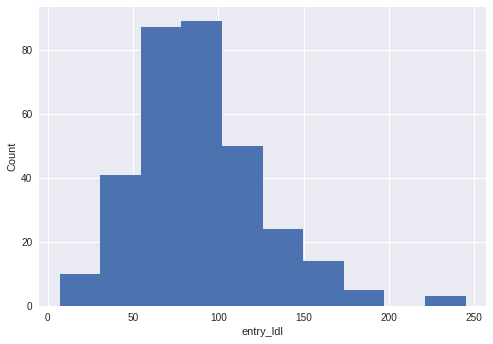

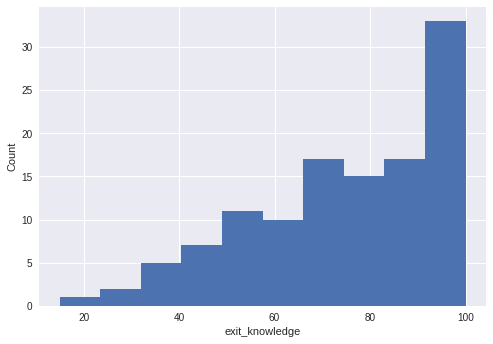

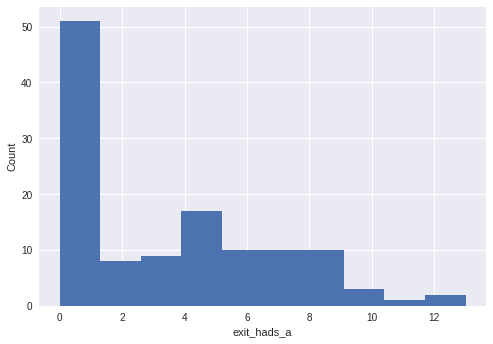

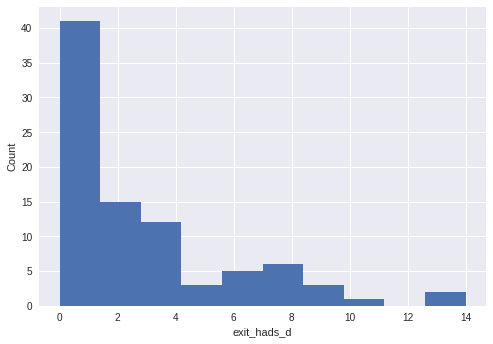

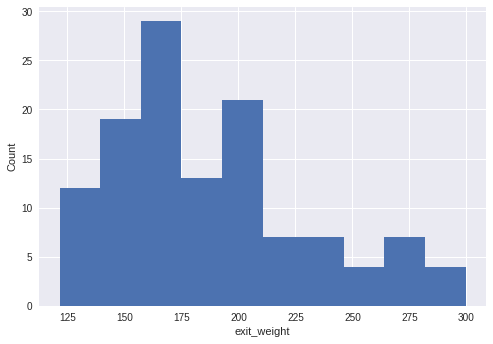

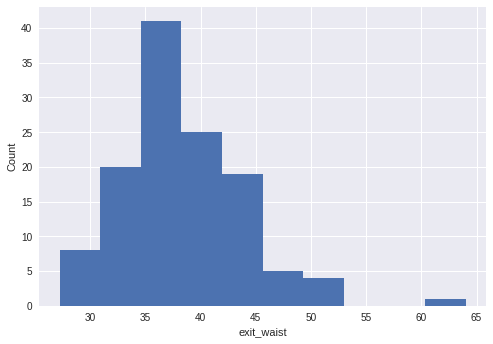

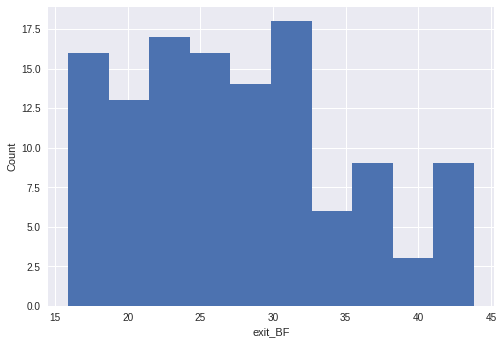

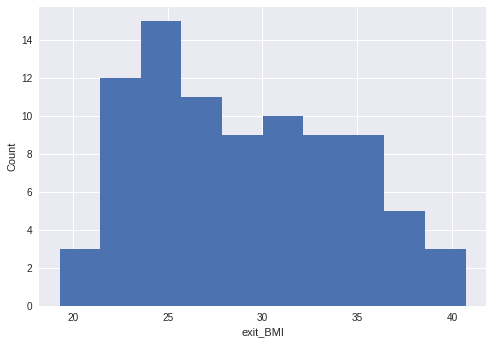

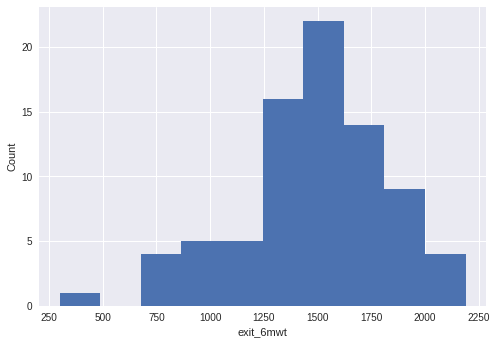

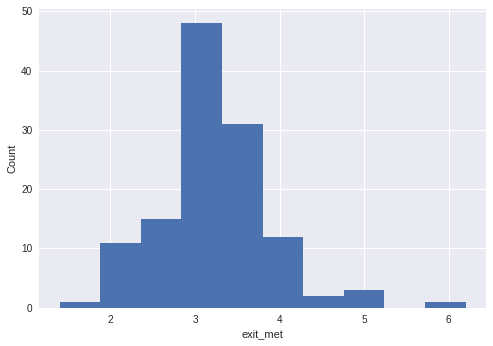

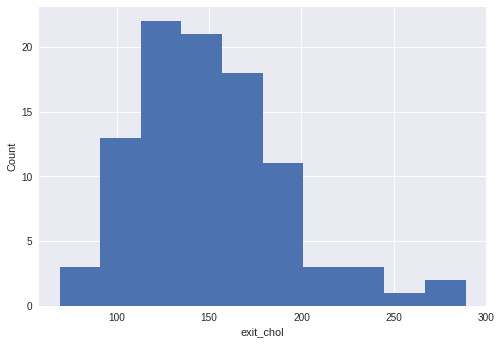

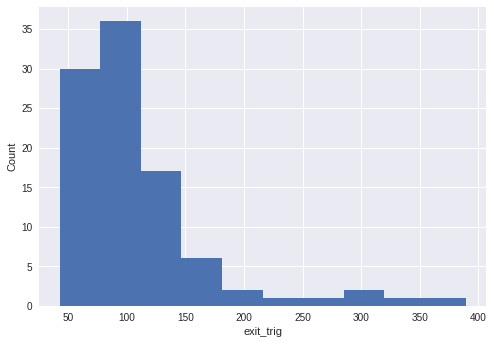

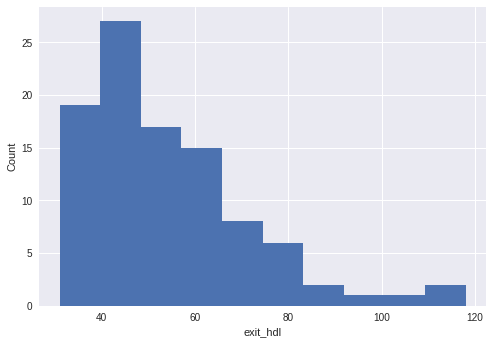

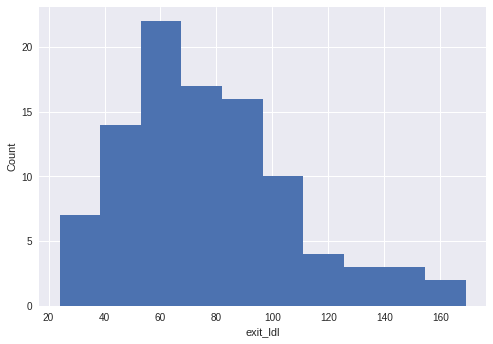

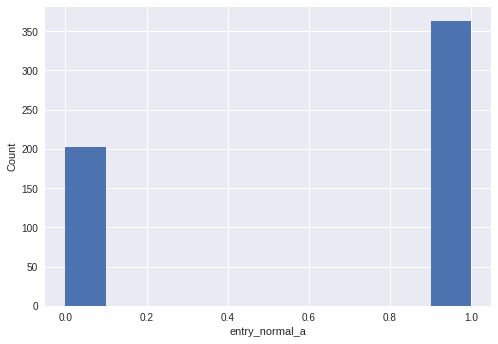

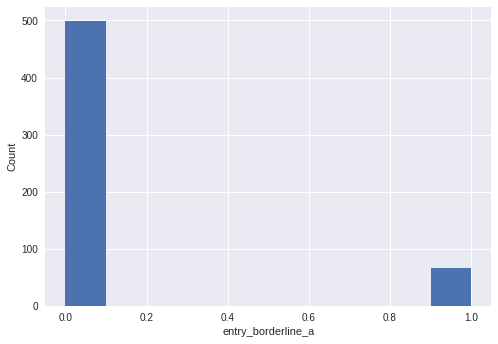

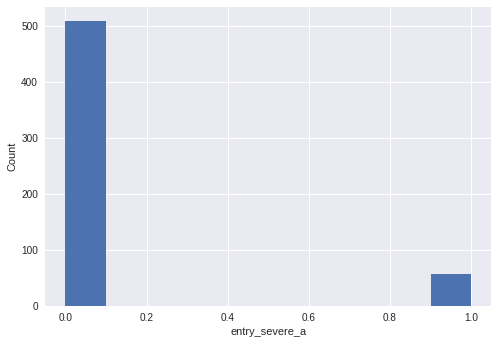

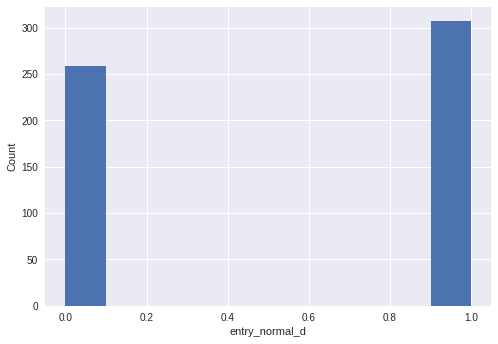

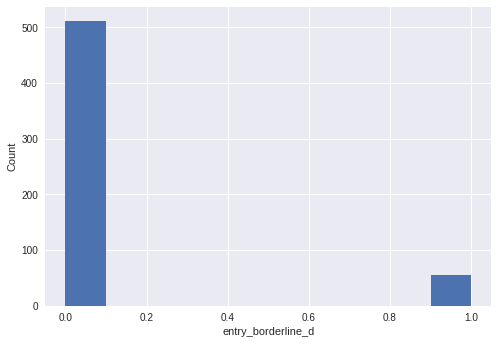

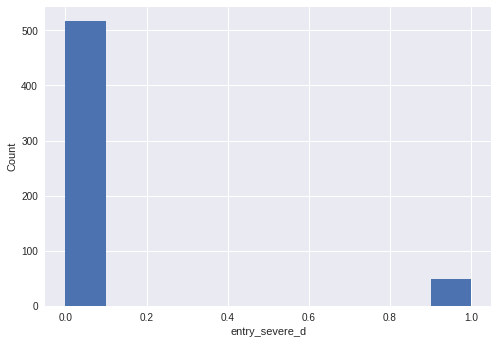

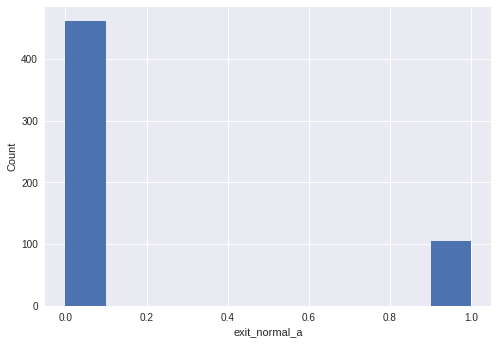

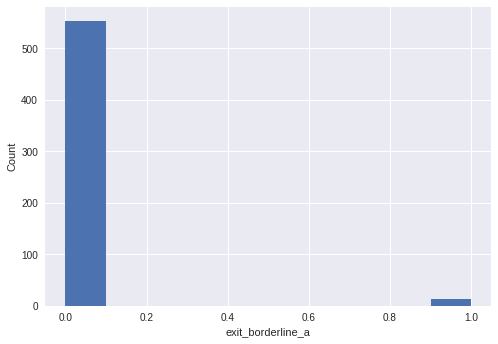

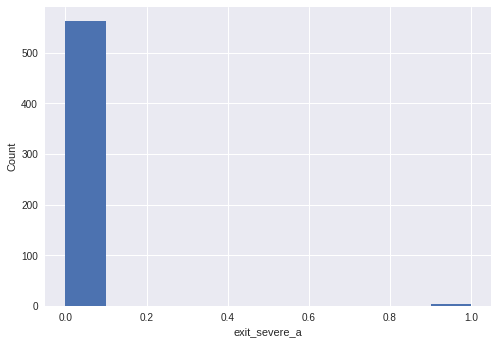

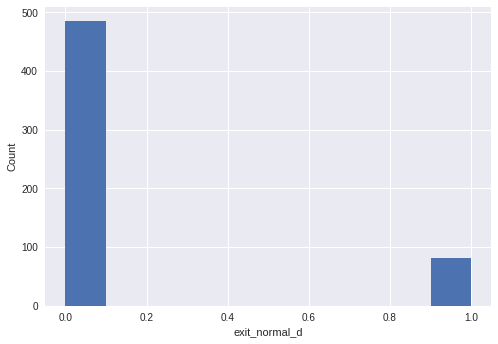

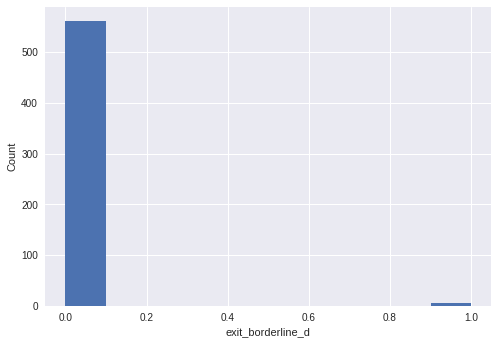

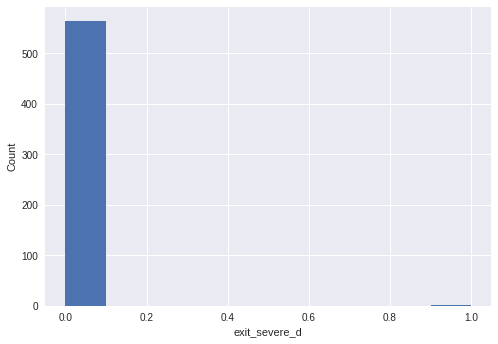

In [0]:
def view_stats(df):
  
  df = create_all_hads_bins(df)
 
  plt.close('all')
  display.display(df.describe())
  print("\nNumber missing in each column:")
  display.display(df.isna().sum())
  
  hads_columns = ['normal', 'borderline', 'severe']
  for timing in ['entry', 'exit']:
    for mood in ['a', 'd']:
      for col in hads_columns:
        print('%s %s (%s) count: ' % (timing, col, mood) + str(df['%s_%s_%s' % (timing, col, mood)].sum()))
        

  plt.close('all')
  for col in df.columns:
    plt.figure()
    plt.hist(df[col])
    plt.xlabel(col)
    plt.ylabel("Count")

    
def create_all_hads_bins(df):
  hads_bins=[-1,7,10,21]
  entry_anxiety_df = pd.get_dummies(pd.cut(df['entry_hads_a'], bins=hads_bins, labels=['entry_normal_a', 'entry_borderline_a', 'entry_severe_a']))
  entry_depression_df = pd.get_dummies(pd.cut(df['entry_hads_d'], bins=hads_bins, labels=['entry_normal_d', 'entry_borderline_d', 'entry_severe_d']))
  exit_anxiety_df = pd.get_dummies(pd.cut(df['exit_hads_a'], bins=hads_bins, labels=['exit_normal_a', 'exit_borderline_a', 'exit_severe_a']))
  exit_depression_df = pd.get_dummies(pd.cut(df['exit_hads_d'], bins=hads_bins, labels=['exit_normal_d', 'exit_borderline_d', 'exit_severe_d']))
  return df.join(entry_anxiety_df).join(entry_depression_df).join(exit_anxiety_df).join(exit_depression_df)

view_stats(patient_dataframe_original)

# **Split into training and test sets**

In [0]:
# Close the matlib plots from view stats to reduce memory usage
plt.close('all')
# Reset the dataframe
patient_dataframe = patient_dataframe_original.copy()

# Set random number seed
rand_state = 4

# Randomize and divide the data set into training and test sets
train_dataframe = patient_dataframe.sample(frac=0.8, random_state=rand_state)
test_dataframe = patient_dataframe.drop(train_dataframe.index)

#test_dataframe.describe()

# **Create methods for cleaning up data**

In [5]:
def process_data(df):
  # Try alternate features and targets
  trial = 2
  
  # Specify features and labels to work with
  if trial==1: # Predict improvement in 6MWT distance after CR
    target_label = 'delta_6mwt'
    numeric_selected_features = ['entry_knowledge', 'entry_height', 'entry_weight', 'entry_waist', 'entry_BF', 'entry_BMI', 'entry_met']
    optional_numeric_selected_features = ['entry_chol', 'entry_trig', 'entry_hdl', 'entry_ldl']
    categorical_selected_features = ['normal_a', 'borderline_a', 'severe_a', 'normal_d', 'borderline_d', 'severe_d']
    
    df = create_synthetic_target(df, target_label)
    
  elif trial==2: # Predict initial exercise tolerance with entry MET
    target_label = 'entry_met'
    numeric_selected_features = ['entry_knowledge', 'entry_height', 'entry_weight', 'entry_waist', 'entry_BF', 'entry_BMI', 'entry_6mwt']
    optional_numeric_selected_features = ['entry_chol', 'entry_trig', 'entry_hdl', 'entry_ldl']
    categorical_selected_features = ['normal_a', 'borderline_a', 'severe_a', 'normal_d', 'borderline_d', 'severe_d']
      
  else:
    return
  
  df = create_features(df)
  df = clean_up_by_target(df, target_label)
  df = remove_outliers(df, 'entry_trig', 1000)
  df = remove_outliers(df, 'entry_6mwt', 2000)
  df = median_impute_missing_values(df) # Temporary  
  df[numeric_selected_features] = scale_features_z_score(df[numeric_selected_features].copy())
  
  # Split into used feature and label dataframes
  feature_df = df[numeric_selected_features+categorical_selected_features]
  target_df = df[target_label]
  
  return feature_df, target_df

# Create synthetic features
def create_features(df):
  df = calculate_bmi(df)
  df = create_hads_bins(df)
  return df

# Create target label of change in 6MWT results  
def create_synthetic_target(df, target):
  df[target] = (df['exit_6mwt'] - df['entry_6mwt'])
  return df
  
# Create categorical bins of anxiety and depression scale
def create_hads_bins(df):
  hads_bins=[-1,7,10,21]
  anxiety_df = pd.get_dummies(pd.cut(df['entry_hads_a'], bins=hads_bins, labels=['normal_a', 'borderline_a', 'severe_a']))
  depression_df = pd.get_dummies(pd.cut(df['entry_hads_d'], bins=hads_bins, labels=['normal_d', 'borderline_d', 'severe_d']))
  return df.join(anxiety_df).join(depression_df) 
  
# Recalculate and fill in BMI from height/weight
def calculate_bmi(df):
  df['calc_bmi'] = (702.95 * df['entry_weight']/(df['entry_height'] ** 2))
  return df

# Remove all rows with values missing in the specified columns
def clean_up_by_target(df, column):
  return df.dropna(subset=[column])

# Remove flagrant outliers by clipping
def remove_outliers(df, feature, maximum):
  df[feature] = df[feature].clip(lower=0, upper=maximum)
  return df

# Replace missing values with the median of the group (temporary measure)
def median_impute_missing_values(df):
  for col in df.columns:
    if df[col].isnull().values.any():
      df[col] = df[col].fillna(df[col].median())
  return df

# Normalize the values of features
def scale_features_z_score(df):
  for col in df.columns:
    df[col] = (df[col] - df[col].mean())/df[col].std()
  return df
  
feature_dataframe, target_dataframe = process_data(train_dataframe)
display.display(feature_dataframe.describe())
display.display(target_dataframe.describe())

,entry_knowledge,entry_height,entry_weight,entry_waist,entry_BF,entry_BMI,entry_6mwt,normal_a,borderline_a,severe_a,normal_d,borderline_d,severe_d
count,395.000,395.000,395.000,395.000,395.000,395.000,395.000,395.000,395.000,395.000,395.000,395.000,395.000
mean,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.722,0.116,0.114,0.600,0.106,0.099
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.449,0.321,0.318,0.491,0.309,0.299
min,-3.421,-3.088,-2.097,-2.586,-2.515,-2.151,-3.060,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.709,-0.397,-0.701,-0.667,-0.754,-0.600,-0.427,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.044,-0.022,-0.164,-0.084,-0.084,-0.154,0.065,1.000,0.000,0.000,1.000,0.000,0.000
75%,0.848,0.604,0.551,0.584,0.719,0.506,0.527,1.000,0.000,0.000,1.000,0.000,0.000
max,1.601,3.106,4.189,4.170,2.512,5.278,3.342,1.000,1.000,1.000,1.000,1.000,1.000


count   395.000
mean      2.543
std       0.477
min       1.100
25%       2.300
50%       2.600
75%       2.900
max       4.400
Name: entry_met, dtype: float64

# **Set up Keras TensorFlow code**

**Set up functions to build and train models**

https://weina.me/nested-cross-validation/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

https://stackoverflow.com/questions/42228735/scikit-learn-gridsearchcv-with-multiple-repetitions/42230764#42230764

In [0]:
# Create a model with various hyperparameters default
def build_model(learn_rate=0.001, neurons=64, dropout_rate=0.0):
  model = keras.Sequential([
      layers.Dense(neurons, activation=tf.nn.relu, input_shape=[len(feature_dataframe.columns)]),
      layers.Dropout(dropout_rate),
      layers.Dense(neurons, activation=tf.nn.relu),
      layers.Dropout(dropout_rate),
      layers.Dense(1)
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(lr=learn_rate)
  
  model.compile(loss='mse',
               optimizer=optimizer,
               metrics=['mae', 'mse'])
  return model

# Train and evaluate the model
def train_model(model, x_train, y_train, x_test, y_test, epochs=100):
  hist = model.fit(
      x = x_train, 
      y = y_train,
      epochs = epochs,
      verbose=0,
      callbacks = [early_stop_call],
      validation_data = (x_test, y_test))
  return hist
  
# Callback function to stop training with no improvement
early_stop_call = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

**Create nested cross-validation for optimal hyperparameter search and model performance estimation**

In [7]:
outer_fold = KFold(n_splits=5, shuffle=True, random_state=rand_state)
inner_fold = KFold(n_splits=5, shuffle=True, random_state=rand_state)

outer_scores = []
inner_scores = []
best_params = []

learn_rate = [0.001, 0.01, 0.1]#, 0.1, 0.25, 0.5]
dropout_rate = [0.0, 0.5, 0.8]#, 0.2, 0.4, 0.6, 0.8]
neurons = [16, 64]#[1, 4, 16, 64]
parameters = dict(learn_rate=learn_rate,
                  dropout_rate=dropout_rate,
                  #neurons=neurons
                 )

inner_model = None
inner_model = KerasRegressor(build_fn=build_model, epochs=500, verbose=0)
grid_estimator = GridSearchCV(estimator=inner_model, param_grid=parameters, scoring='neg_mean_squared_error', cv=inner_fold, verbose=2, iid=False)
#outer_scores = cross_val_score(grid, X=feature_dataframe, y=target_dataframe, scoring='neg_mean_squared_error', cv=outer_fold, verbose=0)

for i, (outer_train_index, outer_test_index) in enumerate(outer_fold.split(train_dataframe)):
  print("Begin fold " + str(i+1))
  
  outer_x_train, outer_y_train = process_data(train_dataframe.iloc[outer_train_index].copy())
  outer_x_test, outer_y_test = process_data(train_dataframe.iloc[outer_test_index].copy())
  
  grid_estimator.fit(outer_x_train, outer_y_train)
  inner_scores.append(grid_estimator.score(outer_x_test, outer_y_test))
  best_params.append(grid_estimator.best_params_)
  print(inner_scores)
  print(best_params)
  
outer_scores.append(sum(inner_scores)/len(inner_scores))
print("Overall score: " + outer_scores)
print(outer_scores)

Begin fold 1
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  20.7s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s remaining:    0.0s


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  17.3s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  16.9s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  16.7s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  17.7s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  18.1s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  18.0s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  18.6s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 17.8min finished


[-0.048432573194979976]
[{'dropout_rate': 0.5, 'learn_rate': 0.001}]
Begin fold 2
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  32.8s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.8s remaining:    0.0s


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  33.7s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  33.6s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  33.9s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  35.1s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  32.6s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  35.2s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  37.7s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 31.6min finished


[-0.048432573194979976, -0.07354103377797906]
[{'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}]
Begin fold 3
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  54.0s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.0s remaining:    0.0s


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  49.5s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  49.9s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  51.6s
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total=  53.0s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  53.2s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  57.2s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total=  53.8s
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 47.1min finished


[-0.048432573194979976, -0.07354103377797906, -0.13264592003069436]
[{'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}]
Begin fold 4
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.2min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.2min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.4min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.3min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.3min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total= 1.3min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total= 1.3min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total= 1.3min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 67.2min finished


[-0.048432573194979976, -0.07354103377797906, -0.13264592003069436, -0.09607956656829761]
[{'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}]
Begin fold 5
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.7min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.8min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.7min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.7min
[CV] dropout_rate=0.0, learn_rate=0.001 ..............................
[CV] ............... dropout_rate=0.0, learn_rate=0.001, total= 1.8min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total= 1.8min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total= 1.9min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] ................ dropout_rate=0.0, learn_rate=0.01, total= 1.8min
[CV] dropout_rate=0.0, learn_rate=0.01 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 91.4min finished


[-0.048432573194979976, -0.07354103377797906, -0.13264592003069436, -0.09607956656829761, -0.08041845871422845]
[{'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}]


AttributeError: ignored

In [13]:
print(inner_scores)
print(best_params)
outer_scores.append(sum(inner_scores)/len(inner_scores))
print(outer_scores)

[-0.048432573194979976, -0.07354103377797906, -0.13264592003069436, -0.09607956656829761, -0.08041845871422845]
[{'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}, {'dropout_rate': 0.5, 'learn_rate': 0.001}]
[-0.0862235104572359, -0.0862235104572359]


# **Old nested CV code**

In [0]:
# Create outer cross-validation loop to assess average performance of hyperparameter model found by inner cross-validation loop
outer_fold = KFold(n_splits=5, shuffle=True, random_state=rand_state)
# Create array to track performance of models identified by inner loop
outer_scores = []

# The outer cross-validation loop
for outfold, (outer_train_index, outer_test_index) in enumerate(outer_fold.split(train_dataframe), 1):
  print("(Outer) Assessing performance on fold " + str(outfold))
  
  outer_feature_train, outer_label_train = process_data(train_dataframe.iloc[outer_train_index].copy())
  outer_feature_test, outer_label_test = process_data(train_dataframe.iloc[outer_test_index].copy())
  
  # Create inner cross-validation loop to optimize hyperparameters
  inner_fold = KFold(n_splits=5, shuffle=True, random_state=rand_state)
  # Create array to track performance of models with each hyperparameter combination
  inner_mean_scores = []
  
  # Assorted hyperparameters to test and the dict compiling them
  learn_rate = [0.001, 0.01]#, 0.1, 0.25, 0.5]
  dropout_rate = [0.0, 0.5]#, 0.2, 0.4, 0.6, 0.8]
  #dropout_rate_2 = dropout_rate_1.copy()
  neurons = [16, 64]#[1, 4, 16, 64]
  #neurons_2 = neurons_1.copy()
  #epochs = [10, 50]#, 100, 1000]
  parameters = dict(#learn_rate=learn_rate,
                    #dropout_rate=dropout_rate,
                    #dropout_rate_2=dropout_rate_2,
                    neurons=neurons,
                    #neurons_2=neurons_2,
                    #epochs=epochs
                   )
  
  # The inner cross-validation loop
  for infold, (inner_train_index, inner_test_index) in enumerate(inner_fold.split(outer_feature_train), 1):
    print("(Inner) Assessing hyperparameter performance on fold " + str(infold))
    
    inner_feature_train, inner_feature_test = outer_feature_train.iloc[inner_train_index], outer_feature_train.iloc[inner_test_index]
    inner_label_train, inner_label_test = outer_label_train.iloc[inner_train_index], outer_label_train.iloc[inner_test_index]
    
    inner_model = KerasRegressor(build_fn=build_model)
    grid = GridSearchCV(estimator=inner_model, param_grid=parameters, scoring='neg_mean_squared_error', cv=3)
    grid_result = grid.fit(inner_feature_train, inner_label_train)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))
  
  
  best_model = None
  best_model = build_model()
  outer_history = train_model(best_model, outer_feature_train, outer_label_train, outer_feature_test, outer_label_test, epochs=100)
  outer_hist = pd.DataFrame(outer_history.history)
  display.display(outer_hist.tail())

(Outer) Assessing performance on fold 1
(Inner) Assessing hyperparameter performance on fold 1
252/252 [==============================] - 0s 2ms/sample - loss: 6.2779 - mean_absolute_error: 2.4336 - mean_squared_error: 6.2779
Best: -3.067360 using {'neurons': 64}
-4.994781 (0.760710) with: {'neurons': 16}
-3.067360 (0.178459) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 2
252/252 [==============================] - 1s 2ms/sample - loss: 3.5705 - mean_absolute_error: 1.7798 - mean_squared_error: 3.5705
Best: -3.368969 using {'neurons': 64}
-4.769016 (0.477469) with: {'neurons': 16}
-3.368969 (0.834800) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 3
252/252 [==============================] - 1s 3ms/sample - loss: 2.7066 - mean_absolute_error: 1.5173 - mean_squared_error: 2.7066
Best: -3.568667 using {'neurons': 64}
-4.260035 (0.297585) with: {'neurons': 16}
-3.568667 (0.103905) with: {'neurons': 64}
(Inner) Assessing hyperparamet

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
95,0.156,0.310,0.156,0.094,0.235,0.094
96,0.153,0.306,0.153,0.096,0.239,0.096
97,0.150,0.301,0.150,0.086,0.224,0.086
98,0.146,0.296,0.146,0.088,0.227,0.088
99,0.143,0.292,0.143,0.089,0.230,0.089


(Outer) Assessing performance on fold 2
(Inner) Assessing hyperparameter performance on fold 1
171/171 [==============================] - 1s 5ms/sample - loss: 5.9260 - mean_absolute_error: 2.3694 - mean_squared_error: 5.9260


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


256/256 [==============================] - 1s 3ms/sample - loss: 3.5352 - mean_absolute_error: 1.7676 - mean_squared_error: 3.5352
Best: -3.019333 using {'neurons': 64}
-4.096120 (0.654263) with: {'neurons': 16}
-3.019333 (0.551953) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 2
172/172 [==============================] - 1s 5ms/sample - loss: 5.0245 - mean_absolute_error: 2.1510 - mean_squared_error: 5.0245


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


257/257 [==============================] - 1s 4ms/sample - loss: 3.4759 - mean_absolute_error: 1.7209 - mean_squared_error: 3.4759
Best: -2.683231 using {'neurons': 64}
-5.159980 (0.940233) with: {'neurons': 16}
-2.683231 (0.174536) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 3
172/172 [==============================] - 1s 6ms/sample - loss: 3.8695 - mean_absolute_error: 1.8583 - mean_squared_error: 3.8695


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


257/257 [==============================] - 1s 4ms/sample - loss: 3.8179 - mean_absolute_error: 1.8492 - mean_squared_error: 3.8179
Best: -2.286386 using {'neurons': 64}
-5.126822 (1.717334) with: {'neurons': 16}
-2.286386 (0.217856) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 4
172/172 [==============================] - 1s 6ms/sample - loss: 5.2126 - mean_absolute_error: 2.2050 - mean_squared_error: 5.2126


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


257/257 [==============================] - 1s 4ms/sample - loss: 4.4057 - mean_absolute_error: 1.9848 - mean_squared_error: 4.4057
Best: -3.339873 using {'neurons': 64}
-4.195506 (1.753846) with: {'neurons': 16}
-3.339873 (1.088709) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 5
172/172 [==============================] - 1s 6ms/sample - loss: 6.4445 - mean_absolute_error: 2.4811 - mean_squared_error: 6.4445


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


257/257 [==============================] - 1s 4ms/sample - loss: 3.8758 - mean_absolute_error: 1.8425 - mean_squared_error: 3.8758
Best: -3.403662 using {'neurons': 64}
-4.818394 (1.562586) with: {'neurons': 16}
-3.403662 (0.606078) with: {'neurons': 64}


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
91,0.087,0.197,0.087,0.086,0.206,0.086
92,0.088,0.197,0.088,0.095,0.227,0.095
93,0.088,0.199,0.088,0.080,0.193,0.080
94,0.087,0.196,0.087,0.084,0.202,0.084
95,0.087,0.196,0.087,0.080,0.191,0.080


(Outer) Assessing performance on fold 3
(Inner) Assessing hyperparameter performance on fold 1
167/167 [==============================] - 1s 7ms/sample - loss: 4.5853 - mean_absolute_error: 2.0704 - mean_squared_error: 4.5853


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


250/250 [==============================] - 1s 5ms/sample - loss: 6.5557 - mean_absolute_error: 2.5119 - mean_squared_error: 6.5557
Best: -2.459351 using {'neurons': 64}
-5.421214 (0.844713) with: {'neurons': 16}
-2.459351 (0.142295) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 2
167/167 [==============================] - 1s 8ms/sample - loss: 3.9390 - mean_absolute_error: 1.8727 - mean_squared_error: 3.9390


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


250/250 [==============================] - 2s 7ms/sample - loss: 3.5277 - mean_absolute_error: 1.7606 - mean_squared_error: 3.5277
Best: -2.970616 using {'neurons': 64}
-5.121244 (0.753339) with: {'neurons': 16}
-2.970616 (0.866074) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 3
167/167 [==============================] - 1s 8ms/sample - loss: 5.4426 - mean_absolute_error: 2.2507 - mean_squared_error: 5.4426


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


250/250 [==============================] - 1s 5ms/sample - loss: 5.8741 - mean_absolute_error: 2.3397 - mean_squared_error: 5.8741
Best: -3.338089 using {'neurons': 64}
-4.314854 (0.420677) with: {'neurons': 16}
-3.338089 (0.022669) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 4
168/168 [==============================] - 1s 8ms/sample - loss: 6.8520 - mean_absolute_error: 2.5609 - mean_squared_error: 6.8520


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


251/251 [==============================] - 1s 6ms/sample - loss: 5.2802 - mean_absolute_error: 2.2041 - mean_squared_error: 5.2802
Best: -3.807395 using {'neurons': 64}
-6.341001 (0.660318) with: {'neurons': 16}
-3.807395 (0.306264) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 5
168/168 [==============================] - 1s 9ms/sample - loss: 6.5373 - mean_absolute_error: 2.4976 - mean_squared_error: 6.5373


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


251/251 [==============================] - 2s 6ms/sample - loss: 3.5851 - mean_absolute_error: 1.7714 - mean_squared_error: 3.5851
Best: -4.121561 using {'neurons': 64}
-5.328840 (0.101047) with: {'neurons': 16}
-4.121561 (0.839249) with: {'neurons': 64}


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
95,0.079,0.188,0.079,0.119,0.234,0.119
96,0.079,0.186,0.079,0.125,0.246,0.125
97,0.078,0.182,0.078,0.120,0.235,0.120
98,0.079,0.189,0.079,0.116,0.227,0.116
99,0.078,0.185,0.078,0.116,0.227,0.116


(Outer) Assessing performance on fold 4
(Inner) Assessing hyperparameter performance on fold 1
167/167 [==============================] - 2s 9ms/sample - loss: 4.0706 - mean_absolute_error: 1.9400 - mean_squared_error: 4.0706


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


250/250 [==============================] - 2s 6ms/sample - loss: 4.5761 - mean_absolute_error: 2.0500 - mean_squared_error: 4.5761
Best: -3.130206 using {'neurons': 64}
-4.626580 (0.588257) with: {'neurons': 16}
-3.130206 (0.643066) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 2
167/167 [==============================] - 2s 9ms/sample - loss: 5.2497 - mean_absolute_error: 2.2486 - mean_squared_error: 5.2497


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


250/250 [==============================] - 2s 6ms/sample - loss: 3.8564 - mean_absolute_error: 1.8556 - mean_squared_error: 3.8564
Best: -3.061955 using {'neurons': 64}
-4.804808 (1.280577) with: {'neurons': 16}
-3.061955 (0.267611) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 3
167/167 [==============================] - 2s 10ms/sample - loss: 3.4544 - mean_absolute_error: 1.7692 - mean_squared_error: 3.4544


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


250/250 [==============================] - 2s 7ms/sample - loss: 3.9474 - mean_absolute_error: 1.8657 - mean_squared_error: 3.9474
Best: -2.133408 using {'neurons': 64}
-5.112575 (0.936510) with: {'neurons': 16}
-2.133408 (0.481917) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 4
168/168 [==============================] - 2s 11ms/sample - loss: 5.0027 - mean_absolute_error: 2.1881 - mean_squared_error: 5.0027


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


251/251 [==============================] - 2s 7ms/sample - loss: 5.7565 - mean_absolute_error: 2.2917 - mean_squared_error: 5.7565
Best: -3.364693 using {'neurons': 64}
-4.640500 (0.854941) with: {'neurons': 16}
-3.364693 (0.816609) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 5
168/168 [==============================] - 2s 10ms/sample - loss: 5.9798 - mean_absolute_error: 2.3963 - mean_squared_error: 5.9798


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


251/251 [==============================] - 2s 7ms/sample - loss: 4.4226 - mean_absolute_error: 1.9888 - mean_squared_error: 4.4226
Best: -2.824739 using {'neurons': 64}
-5.208573 (0.731259) with: {'neurons': 16}
-2.824739 (0.188834) with: {'neurons': 64}


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
95,0.081,0.194,0.081,0.101,0.211,0.101
96,0.080,0.194,0.080,0.101,0.217,0.101
97,0.080,0.194,0.080,0.101,0.210,0.101
98,0.080,0.194,0.080,0.100,0.211,0.100
99,0.080,0.194,0.080,0.100,0.210,0.100


(Outer) Assessing performance on fold 5
(Inner) Assessing hyperparameter performance on fold 1
170/170 [==============================] - 2s 11ms/sample - loss: 3.5319 - mean_absolute_error: 1.7668 - mean_squared_error: 3.5319


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


254/254 [==============================] - 2s 7ms/sample - loss: 3.4842 - mean_absolute_error: 1.7345 - mean_squared_error: 3.4842
Best: -2.716081 using {'neurons': 64}
-5.505947 (1.008215) with: {'neurons': 16}
-2.716081 (0.706466) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 2
170/170 [==============================] - 2s 11ms/sample - loss: 5.0593 - mean_absolute_error: 2.1738 - mean_squared_error: 5.0593


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


254/254 [==============================] - 2s 8ms/sample - loss: 5.6618 - mean_absolute_error: 2.2760 - mean_squared_error: 5.6618
Best: -3.026513 using {'neurons': 64}
-4.014593 (0.340677) with: {'neurons': 16}
-3.026513 (0.280960) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 3
170/170 [==============================] - 2s 12ms/sample - loss: 4.2406 - mean_absolute_error: 1.9906 - mean_squared_error: 4.2406


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


254/254 [==============================] - 2s 8ms/sample - loss: 5.7678 - mean_absolute_error: 2.2615 - mean_squared_error: 5.7678
Best: -2.017688 using {'neurons': 64}
-5.377189 (0.849823) with: {'neurons': 16}
-2.017688 (0.216518) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 4
255/255 [==============================] - 2s 8ms/sample - loss: 3.7050 - mean_absolute_error: 1.8376 - mean_squared_error: 3.7050
Best: -3.431604 using {'neurons': 64}
-4.368450 (1.136877) with: {'neurons': 16}
-3.431604 (0.376224) with: {'neurons': 64}
(Inner) Assessing hyperparameter performance on fold 5
255/255 [==============================] - 2s 8ms/sample - loss: 5.5753 - mean_absolute_error: 2.2654 - mean_squared_error: 5.5753
Best: -3.769269 using {'neurons': 64}
-5.231784 (0.657668) with: {'neurons': 16}
-3.769269 (1.585014) with: {'neurons': 64}


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
95,0.105,0.222,0.105,0.087,0.218,0.087
96,0.104,0.222,0.104,0.087,0.219,0.087
97,0.103,0.218,0.103,0.086,0.217,0.086
98,0.102,0.216,0.102,0.087,0.219,0.087
99,0.102,0.218,0.102,0.086,0.217,0.086


# **Old, working standalone cross validation**

In [0]:
def build_model(train_df):
  model = keras.Sequential([
      layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu, input_shape=[len(train_df.columns)]),
      layers.Dropout(0.5),
      layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu),
      layers.Dropout(0.5),
      layers.Dense(100, kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu),
      layers.Dense(1)
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  
  model.compile(loss='mse',
               optimizer=optimizer,
               metrics=['mae', 'mse'])
  return model

# Train and evaluate the model
def train_model(model, x_train, y_train, x_test, y_test, early_stop):
  if(early_stop):
    hist = model.fit(
        x = x_train, 
        y = y_train,
        epochs = EPOCHS,
        verbose=1,
        callbacks = [early_stop_call],
        validation_data = (x_test, y_test)
    )
  else:
    hist = model.fit(
        x = x_train, 
        y = y_train,
        epochs = EPOCHS,
        validation_data = (x_test, y_test)
    )
  return hist
  
# Stop training with no improvement
early_stop_call = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 1000
end_fold_error = pd.DataFrame(columns=['loss', 'MAE', 'MSE', 'test_loss', 'test_MAE', 'test_MSE'])
  
# Create cross validator
kf = KFold(n_splits=10, shuffle=True, random_state=4)

# Loop through the k folds for cross validation
for i, (train_index, test_index) in enumerate(kf.split(train_dataframe), 1):
  print("Training on fold " + str(i))
  
  #feature_train, feature_test = feature_data.iloc[train_index].copy(), feature_data.iloc[test_index].copy()
  #label_train, label_test = label_data.iloc[train_index], label_data.iloc[test_index]
  
  feature_train, label_train = process_data(train_dataframe.iloc[train_index].copy())
  feature_test, label_test = process_data(train_dataframe.iloc[test_index].copy())
  
  model = None
  model = build_model(feature_train)
  
  history = train_model(model, feature_train, label_train, feature_test, label_test, early_stop=True)
  mse_history = history.history['mean_squared_error']
  val_mse_history = history.history['val_mean_squared_error']
  end_fold_error = end_fold_error.append(
      pd.Series([history.history['loss'][-1],
                 history.history['mean_absolute_error'][-1],
                 mse_history[-1], 
                 history.history['val_loss'][-1],
                 history.history['val_mean_absolute_error'][-1],
                 val_mse_history[-1]], 
                index=end_fold_error.columns), ignore_index=True)
  print("Last training error: " + str(mse_history[-1]))
  print("Last validation error: " + str(val_mse_history[-1]))

# **Generate final model with optimal hyperparameters and evaluate performance**

In [0]:
end_fold_error = pd.DataFrame()

# Loop through the k folds for cross validation
for i, (train_index, test_index) in enumerate(kf.split(train_dataframe), 1):
  print("Training on fold " + str(i))
  
  feature_train, label_train = process_data(train_dataframe.iloc[train_index].copy())
  feature_test, label_test = process_data(train_dataframe.iloc[test_index].copy())
  
  model = None
  model = build_model()
  
  history = train_model(model, feature_train, label_train, feature_test, label_test)
  mse_history = history.history['mean_squared_error']
  val_mse_history = history.history['val_mean_squared_error']
  end_fold_error = end_fold_error.append(
      pd.Series([history.history['loss'][-1],
                 history.history['mean_absolute_error'][-1],
                 mse_history[-1], 
                 history.history['val_loss'][-1],
                 history.history['val_mean_absolute_error'][-1],
                 val_mse_history[-1]]
                ), ignore_index=True)
  print("Last training error: " + str(mse_history[-1]))
  print("Last validation error: " + str(val_mse_history[-1]))

#hist = pd.DataFrame(history.history)
#hist['epoch'] = history.epoch
#hist.tail()

**View error trends**

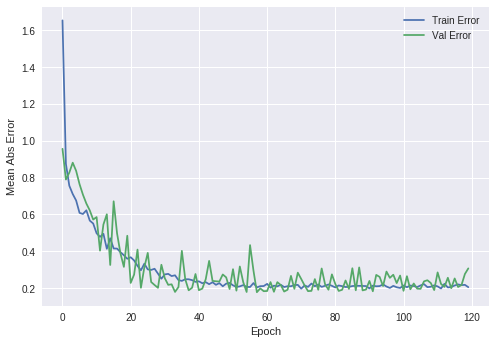

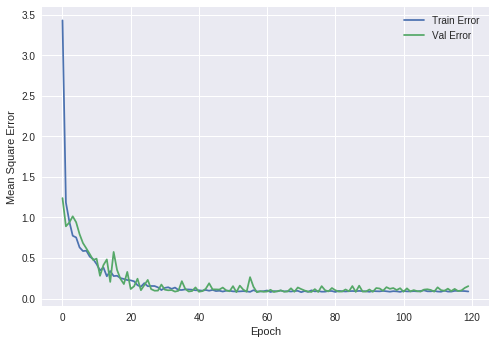

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  #plt.ylim([0,3])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  #plt.ylim([0,5])

plot_history(history)

**Assess model performance on test data**

In [0]:
test_features, test_label = process_data(test_dataframe)
loss, mae, mse = model.evaluate(test_features, test_label, verbose=0)

print("Testing set Loss: {:5.2f}".format(loss))
print("Testing set Mean Abs Error: {:5.2f}".format(mae))
print("Testing set Mean Squared Error: {:5.2f}".format(mse))

Testing set Loss:  0.34
Testing set Mean Abs Error:  0.23
Testing set Mean Squared Error:  0.28


(0, 1182.5841960545788)

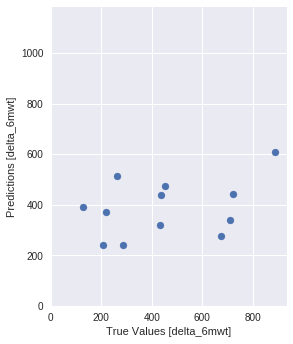

In [0]:
test_predictions = model.predict(test_features).flatten()

plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [delta_6mwt]')
plt.ylabel('Predictions [delta_6mwt]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

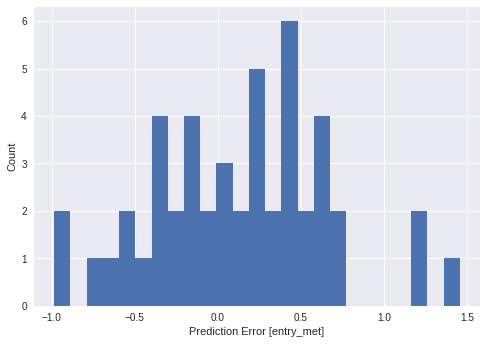

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel('Prediction Error ['+target_feature[0]+']')
_ = plt.ylabel('Count')